# Outage Probability Results

These results plot our simulation metrics against increasing outage probability (and therefore increasing durations of outages). 

## Multiple Results Analysis

This notebook is intended to read a simulation results file with multiple simulations and results and create aggregate analyses and visualizations.

**Experimental control variables:**

- _increasing WAN latency, e.g. T (tick)_
- increasing number of nodes
- increasing amounts of failure

**Metrics:**

- number of forks
- number of stale reads
- percent visible (for full replication)
- percent committed
- number of messages
- read latency
- write latency
- visibility latency
- commit latency

In [1]:
%load_ext memory_profiler
%matplotlib inline

import os
import sys 
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib as mpl
import graph_tool.all as gt
import matplotlib.pyplot as plt

from operator import itemgetter
from itertools import groupby, chain
from collections import defaultdict, Counter

# Modify the Notebook path
sys.path.append(os.path.join(os.getcwd(), ".."))

from cloudscope.colors import ColorMap
from cloudscope.results import Results
from cloudscope.results.graph import extract_graph
from cloudscope.results.analysis import create_per_replica_dataframe as create_replica_dataframe
from cloudscope.results.analysis import create_per_experiment_dataframe as create_dataframe

In [2]:
sns.set_style('whitegrid')
sns.set_context('poster')
sns.set_palette('Set1')

In [3]:
# Specify a path to a results file 
# If None, will attempt to look one up
FIXTURES = os.path.join("..", "fixtures", "results")

FIGURES  = os.path.join("..", "fixtures", "figures", "outages-experiment")
RESULTS  = os.path.join(FIXTURES, "federated-outages-20161129.json")

def get_results_data(path=RESULTS):
    with open(path, 'r') as f:
        for line in f:
            yield Results.load(line)

In [4]:
%%memit 
df = create_dataframe(get_results_data())

peak memory: 398.44 MiB, increment: 270.74 MiB


In [5]:
# Uncomment below if you need to see the columns
# print("\n".join(df.columns))

# Add the ename to identify the experiment
df['ename'] = "Po = " + df['outage probability'].apply(str) + " " + df['type']
df['type']  = df['type'].apply(lambda s: s.title())

In [6]:
df['outage probability'] = df['outage probability'].apply(float)

In [7]:
df = df.sort_values(['type'])
markers=["x","D","o"]

In [ ]:
%%memit

def get_message_rows(df):
    for row in df[['message types', 'tick metric (T)', 'type', 'eid', 'users', 'T parameter model', 'outage probability']].itertuples(): 
        item = row[1]
        item['experiment'] = "{} Po = {:0.2f}".format(row[3], row[7])
        yield item

# Create the data frame 
msgs = pd.DataFrame(sorted(get_message_rows(df), key=lambda item: item['experiment']))

# Create the figure 
fig = plt.figure(figsize=(14,48))
ax  = fig.add_subplot(111)
mpl.rcParams.update({'font.size': 22})

# Plot the bar chart 
g = msgs.plot(
    x='experiment', kind='barh', stacked=True, ax=ax, 
    title="Message Counts by Type", color=sns.color_palette()
)

# Modify the figure 
ax.set_xlabel("message count")
ax.yaxis.grid(False)

# Save the figure to disk 
plt.savefig(os.path.join(FIGURES, 'message_counts.pdf'))

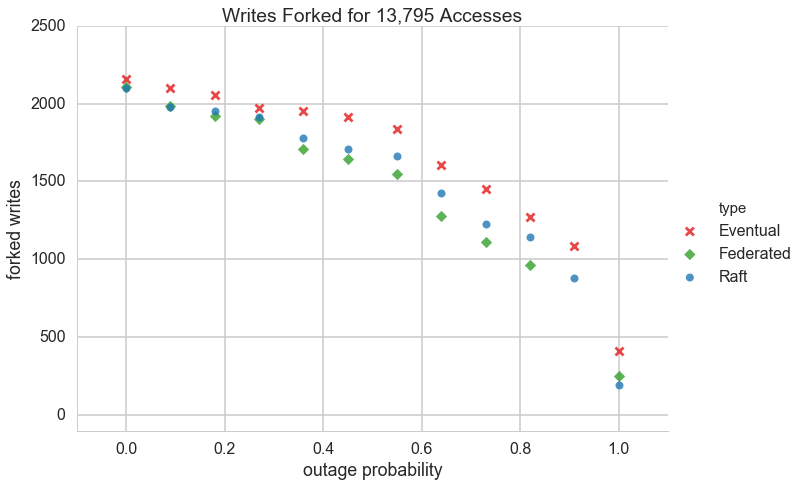

In [8]:
# Forked Writes (two keys: "inconsistent writes" and "forked writes")
g = sns.lmplot(
    x="outage probability", y="forked writes", hue='type',
    data=df, fit_reg=False, size=7, aspect=1.4, markers=markers,
    palette=["#e31a1c", "#33a02c", "#1f78b4"],
    scatter_kws={'s': 64}
)

# Set the title and the labels 
title_fmt = "Writes Forked for {:,} Accesses".format(df.writes.max())
g.ax.set_title(title_fmt)

# Modify the axis limits  
for ax in g.axes:
    ax[0].set_ylim(-100,)
    ax[0].set_xlim(-0.1,1.1)

# Save the figure to disk 
plt.savefig(os.path.join(FIGURES, 'forked_writes.pdf'))

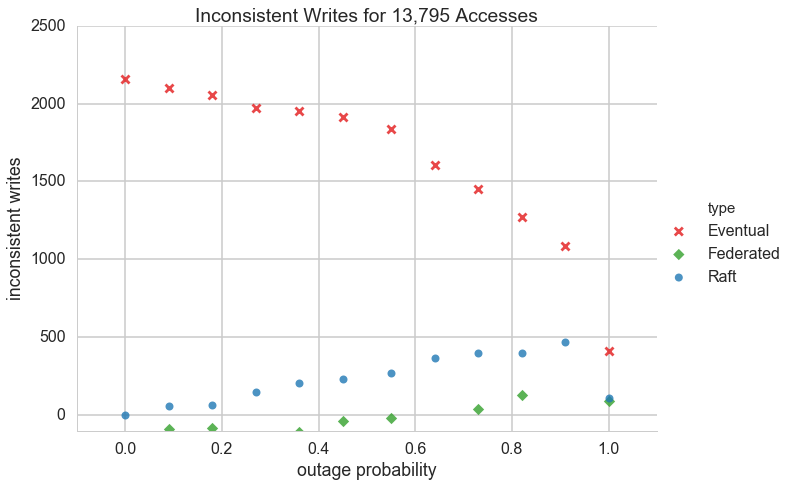

In [9]:
# Forked Writes (two keys: "inconsistent writes" and "forked writes")
g = sns.lmplot(
    x="outage probability", y="inconsistent writes", hue='type',
    data=df, fit_reg=False, size=7, aspect=1.4, markers=markers,
    palette=["#e31a1c", "#33a02c", "#1f78b4"],
    scatter_kws={'s': 64}
)

# Set the title and the labels 
title_fmt = "Inconsistent Writes for {:,} Accesses".format(df.writes.max())
g.ax.set_title(title_fmt)

# Modify the axis limits  
for ax in g.axes:
    ax[0].set_ylim(-100,)
    ax[0].set_xlim(-0.1,1.1)

# Save the figure to disk 
plt.savefig(os.path.join(FIGURES, 'inconsistent_writes.pdf'))

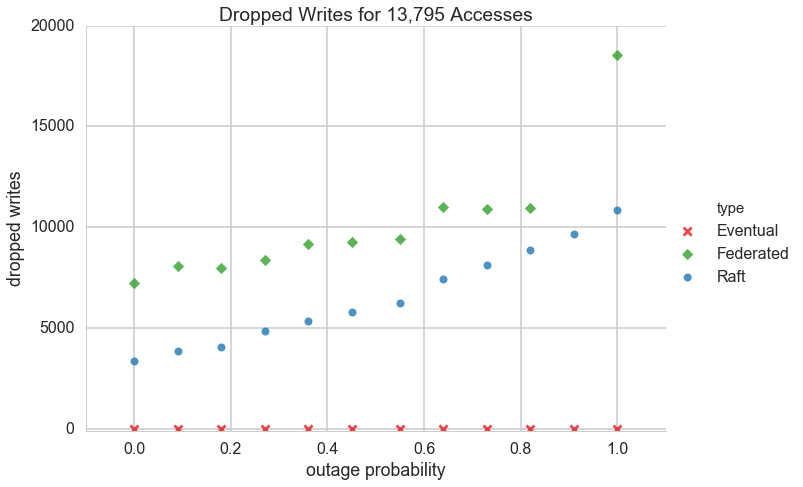

In [10]:
# Dropped Writes
g = sns.lmplot(
    x="outage probability", y="dropped writes", hue='type', 
    data=df, fit_reg=False, size=7, aspect=1.4, markers=markers,
    palette=["#e31a1c", "#33a02c", "#1f78b4"],
    scatter_kws={'s': 64}
)

# Set the title and the labels 
title_fmt = "Dropped Writes for {:,} Accesses".format(df.writes.max())
g.ax.set_title(title_fmt)

# Modify the axis limits  
for ax in g.axes:
    ax[0].set_ylim(-100,)
    ax[0].set_xlim(-0.1,1.1)

# Save the figure to disk 
plt.savefig(os.path.join(FIGURES, 'dropped_writes.pdf'))

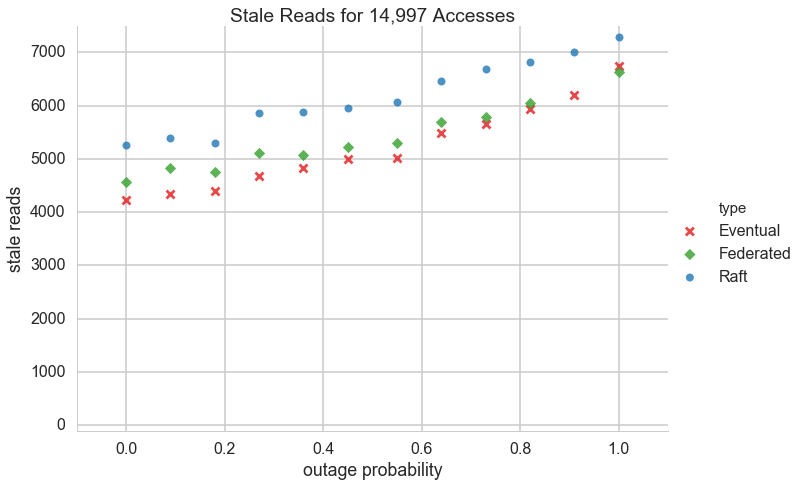

In [11]:
# Stale Reads
g = sns.lmplot(
    x="outage probability", y="stale reads", hue='type', 
    data=df, fit_reg=False, size=7, aspect=1.4, markers=markers,
    palette=["#e31a1c", "#33a02c", "#1f78b4"],
    scatter_kws={'s': 64}
)

# Set the title and the labels 
title_fmt = "Stale Reads for {:,} Accesses".format(df.reads.max())
g.ax.set_title(title_fmt)

# Modify the axis limits  
for ax in g.axes:
    ax[0].set_ylim(-100,)
    ax[0].set_xlim(-0.1,1.1)

# Save the figure to disk 
plt.savefig(os.path.join(FIGURES, 'stale_reads.pdf'))

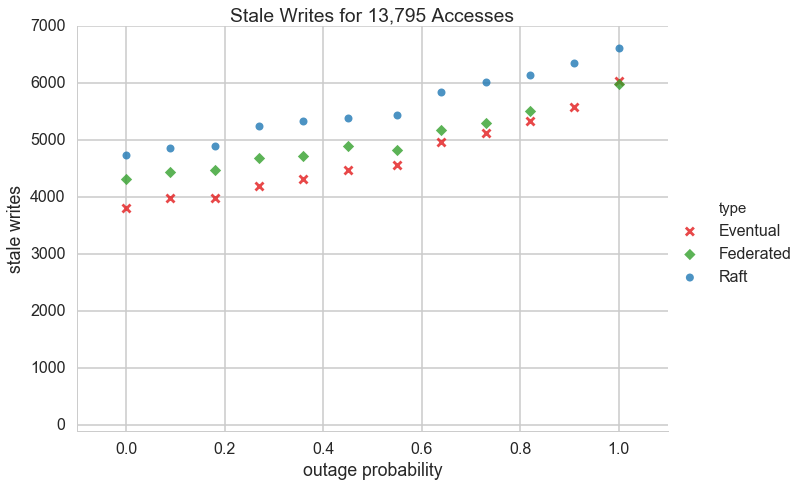

In [12]:
# Stale Writes
g = sns.lmplot(
    x="outage probability", y="stale writes", hue='type', 
    data=df, fit_reg=False, size=7, aspect=1.4, markers=markers,
    palette=["#e31a1c", "#33a02c", "#1f78b4"],
    scatter_kws={'s': 64}
)

# Set the title and the labels 
title_fmt = "Stale Writes for {:,} Accesses".format(df.writes.max())
g.ax.set_title(title_fmt)

# Modify the axis limits  
for ax in g.axes:
    ax[0].set_ylim(-100,)
    ax[0].set_xlim(-0.1,1.1)

# Save the figure to disk 
plt.savefig(os.path.join(FIGURES, 'stale_writes.pdf'))

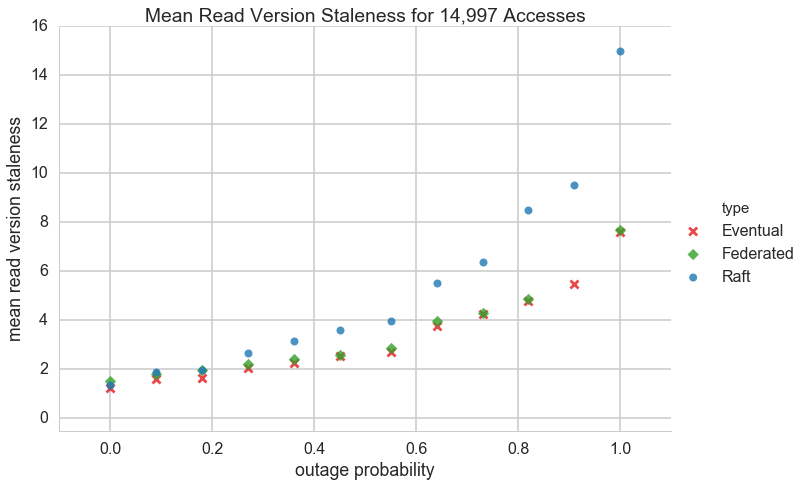

In [13]:
# Version Staleness
g = sns.lmplot(
    x="outage probability", y="mean read version staleness", hue='type', 
    data=df, fit_reg=False, size=7, aspect=1.4, markers=markers,
    palette=["#e31a1c", "#33a02c", "#1f78b4"],
    scatter_kws={'s': 64}
)

# Set the title and the labels 
title_fmt = "Mean Read Version Staleness for {:,} Accesses".format(df.reads.max())
g.ax.set_title(title_fmt)

# Modify the axis limits  
for ax in g.axes:
    ax[0].set_ylim(-0.5,)
    ax[0].set_xlim(-0.1,1.1)

# Save the figure to disk 
plt.savefig(os.path.join(FIGURES, 'mean_version_staleness.pdf'))

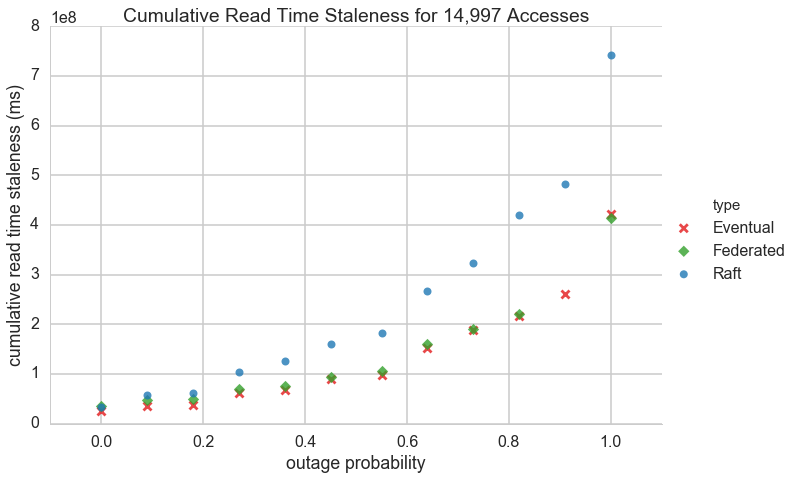

In [14]:
# Cumulative Time Staleness
g = sns.lmplot(
    x="outage probability", y="cumulative read time staleness (ms)", hue='type', 
    data=df, fit_reg=False, size=7, aspect=1.4, markers=markers,
    palette=["#e31a1c", "#33a02c", "#1f78b4"],
    scatter_kws={'s': 64}
)

# Set the title and the labels 
title_fmt = "Cumulative Read Time Staleness for {:,} Accesses".format(df.reads.max())
g.ax.set_title(title_fmt)

# Modify the axis limits  
for ax in g.axes:
    ax[0].set_ylim(0,)
    ax[0].set_xlim(-0.1,1.1)

# Save the figure to disk 
plt.savefig(os.path.join(FIGURES, 'cumulative_read_time_staleness.pdf'))

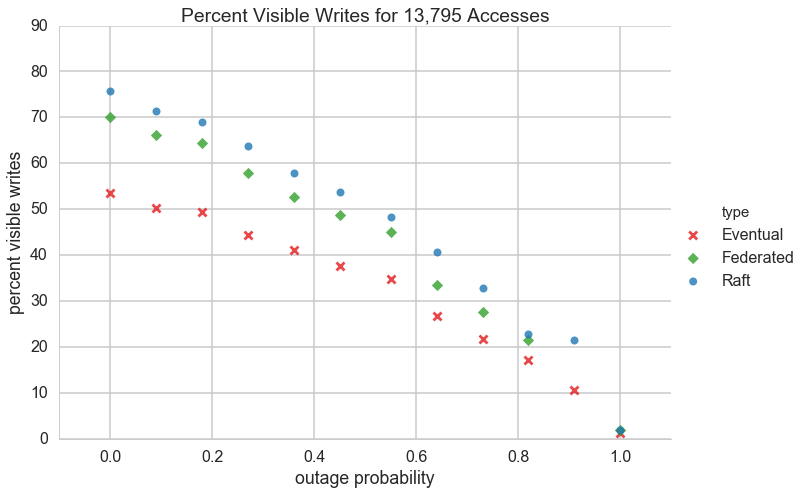

In [15]:
df['percent visible writes'] = (df['visible writes'] / df['writes']) * 100

# Visible Writes
g = sns.lmplot(
    x="outage probability", y="percent visible writes", hue='type', 
    data=df, fit_reg=False, size=7, aspect=1.4, markers=markers,
    palette=["#e31a1c", "#33a02c", "#1f78b4"],
    scatter_kws={'s': 64}
)

# Set the title and the labels 
title_fmt = "Percent Visible Writes for {:,} Accesses".format(df.writes.max())
g.ax.set_title(title_fmt)

# Modify the axis limits  
for ax in g.axes:
    ax[0].set_ylim(0,)
    ax[0].set_xlim(-0.1,1.1)

# Save the figure to disk 
plt.savefig(os.path.join(FIGURES, 'visible_writes.pdf'))

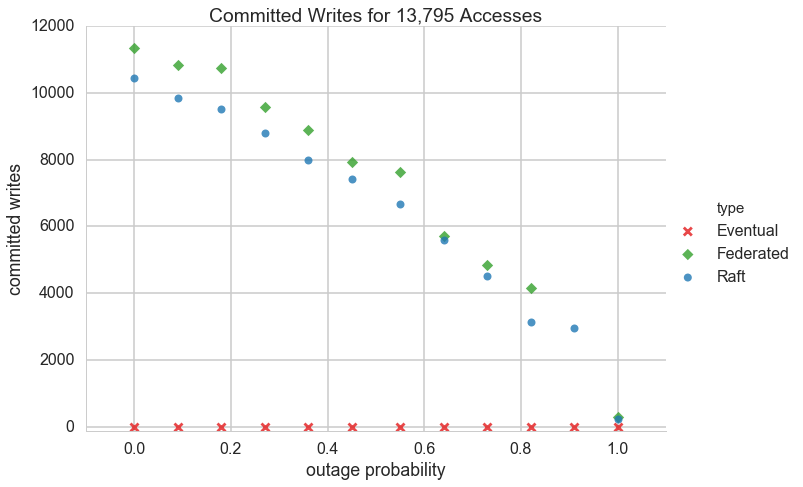

In [16]:
# Comitted Writes
g = sns.lmplot(
    x="outage probability", y="committed writes", hue='type', 
    data=df, fit_reg=False, size=7, aspect=1.4, markers=markers,
    palette=["#e31a1c", "#33a02c", "#1f78b4"],
    scatter_kws={'s': 64}
)

# Set the title and the labels 
title_fmt = "Committed Writes for {:,} Accesses".format(df.writes.max())
g.ax.set_title(title_fmt)

# Modify the axis limits  
for ax in g.axes:
    ax[0].set_ylim(-100,)
    ax[0].set_xlim(-0.1,1.1)

# Save the figure to disk 
plt.savefig(os.path.join(FIGURES, 'committed_writes.pdf'))

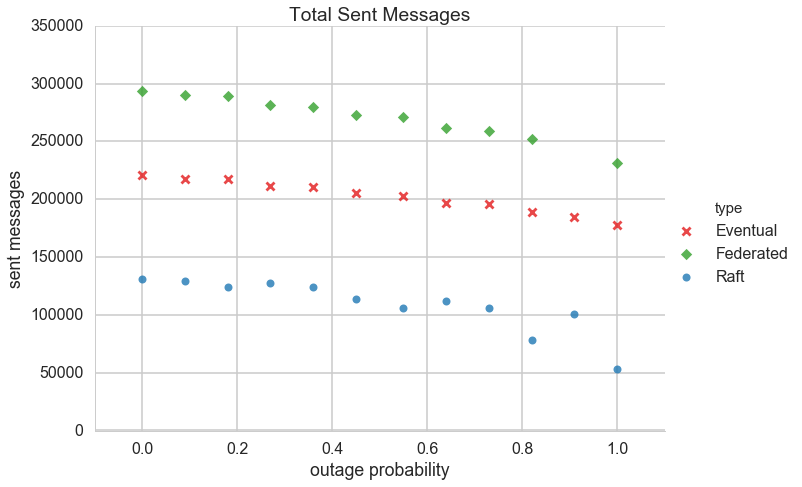

In [17]:
# Number of Messages 
g = sns.lmplot(
    x="outage probability", y="sent messages", hue='type', 
    data=df, fit_reg=False, size=7, aspect=1.4, markers=markers,
    palette=["#e31a1c", "#33a02c", "#1f78b4"],
    scatter_kws={'s': 64}
)

# Set the title and the labels 
title_fmt = "Total Sent Messages"
g.ax.set_title(title_fmt)

# Modify the axis limits  
for ax in g.axes:
    ax[0].set_ylim(-100,)
    ax[0].set_xlim(-0.1,1.1)

# Save the figure to disk 
plt.savefig(os.path.join(FIGURES, 'messages_sent.pdf'))

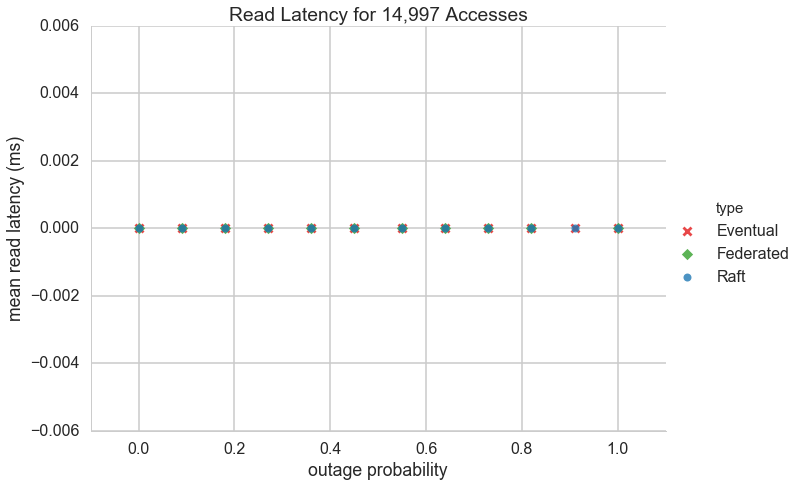

In [18]:
# Read cost (ms delay before read)
g = sns.lmplot(
    x="outage probability", y="mean read latency (ms)", hue='type', 
    data=df, fit_reg=False, size=7, aspect=1.4, markers=markers,
    palette=["#e31a1c", "#33a02c", "#1f78b4"],
    scatter_kws={'s': 64}
)

# Set the title and the labels 
title_fmt = "Read Latency for {:,} Accesses".format(df.reads.max())
g.ax.set_title(title_fmt)

# Modify the axis limits  
for ax in g.axes:
    ax[0].set_xlim(-0.1,1.1)

# Save the figure to disk 
plt.savefig(os.path.join(FIGURES, 'read_latency.pdf'))

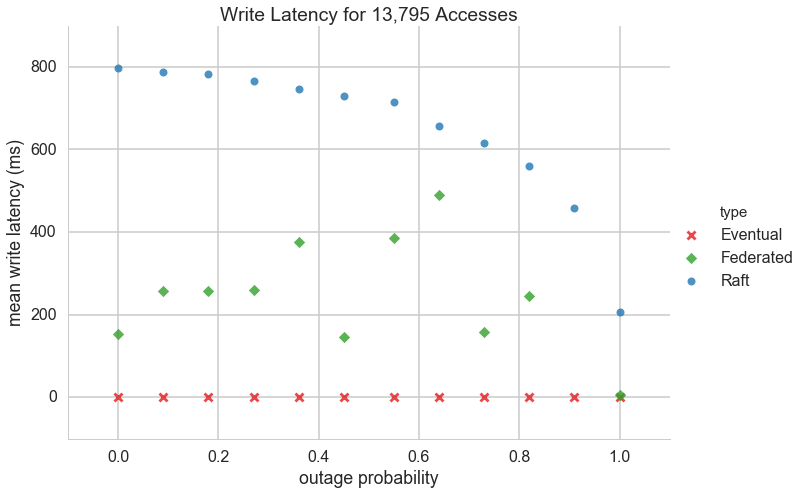

In [19]:
# Write Cost (ms delay before write)
g = sns.lmplot(
    x="outage probability", y="mean write latency (ms)", hue='type', 
    data=df, fit_reg=False, size=7, aspect=1.4, markers=markers,
    palette=["#e31a1c", "#33a02c", "#1f78b4"],
    scatter_kws={'s': 64}
)

# Set the title and the labels 
title_fmt = "Write Latency for {:,} Accesses".format(df.writes.max())
g.ax.set_title(title_fmt)

# Modify the axis limits  
for ax in g.axes:
    ax[0].set_ylim(-100,)
    ax[0].set_xlim(-0.1,1.1)

# Save the figure to disk 
plt.savefig(os.path.join(FIGURES, 'write_latency.pdf'))

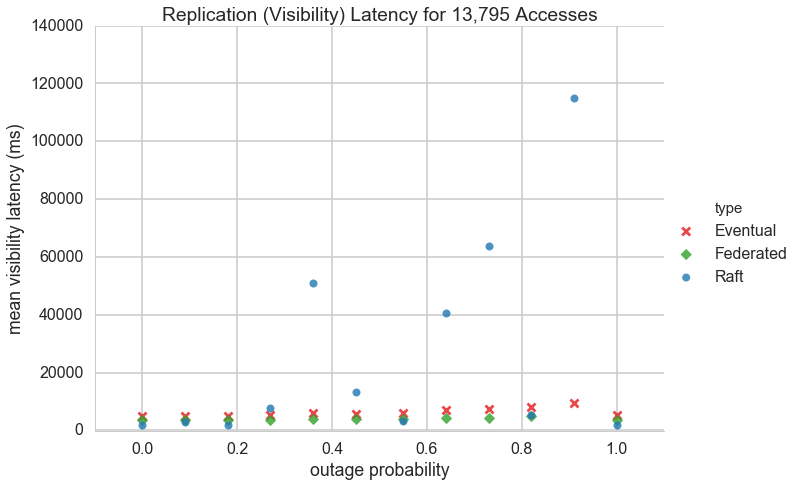

In [20]:
# Replication Cost (Visibility Latency)
g = sns.lmplot(
    x="outage probability", y="mean visibility latency (ms)", hue='type', 
    data=df, fit_reg=False, size=7, aspect=1.4, markers=markers,
    palette=["#e31a1c", "#33a02c", "#1f78b4"],
    scatter_kws={'s': 64}
)

# Set the title and the labels 
title_fmt = "Replication (Visibility) Latency for {:,} Accesses".format(df.writes.max())
g.ax.set_title(title_fmt)

# Modify the axis limits  
for ax in g.axes:
    ax[0].set_ylim(-100,)
    ax[0].set_xlim(-0.1,1.1)

# Save the figure to disk 
plt.savefig(os.path.join(FIGURES, 'visibility_latency.pdf'))

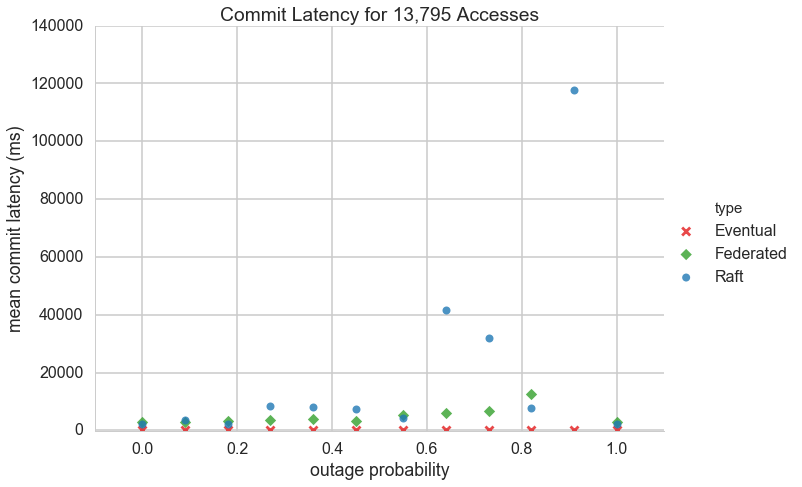

In [21]:
# Commit Cost (Commit Latency)
g = sns.lmplot(
    x="outage probability", y="mean commit latency (ms)", hue='type', 
    data=df, fit_reg=False, size=7, aspect=1.4, markers=markers,
    palette=["#e31a1c", "#33a02c", "#1f78b4"],
    scatter_kws={'s': 64}
)

# Set the title and the labels 
title_fmt = "Commit Latency for {:,} Accesses".format(df.writes.max())
g.ax.set_title(title_fmt)

# Modify the axis limits  
for ax in g.axes:
    ax[0].set_ylim(-100,)
    ax[0].set_xlim(-0.1,1.1)

# Save the figure to disk 
plt.savefig(os.path.join(FIGURES, 'commit_latency.pdf'))

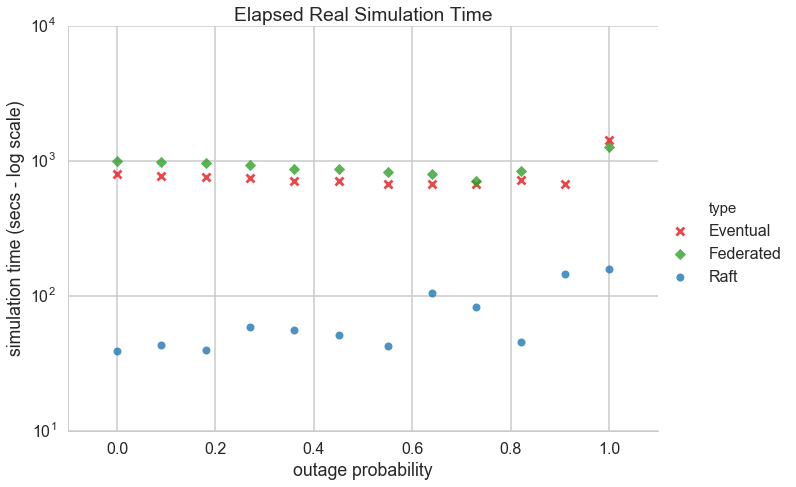

In [22]:
# Simulation Time
g = sns.lmplot(
    x="outage probability", y="simulation time (secs)", hue='type', 
    data=df, fit_reg=False, size=7, aspect=1.4, markers=markers,
    palette=["#e31a1c", "#33a02c", "#1f78b4"],
    scatter_kws={'s': 64}
)

# Set the title and the labels 
title_fmt = "Elapsed Real Simulation Time"
g.ax.set_title(title_fmt)
g.set(yscale="log")
g.set(ylabel="simulation time (secs - log scale)")

# Modify the axis limits  
for ax in g.axes:
#     ax[0].set_ylim(-100,)
    ax[0].set_xlim(-0.1,1.1)

# Save the figure to disk 
plt.savefig(os.path.join(FIGURES, 'simulation_time.pdf'))

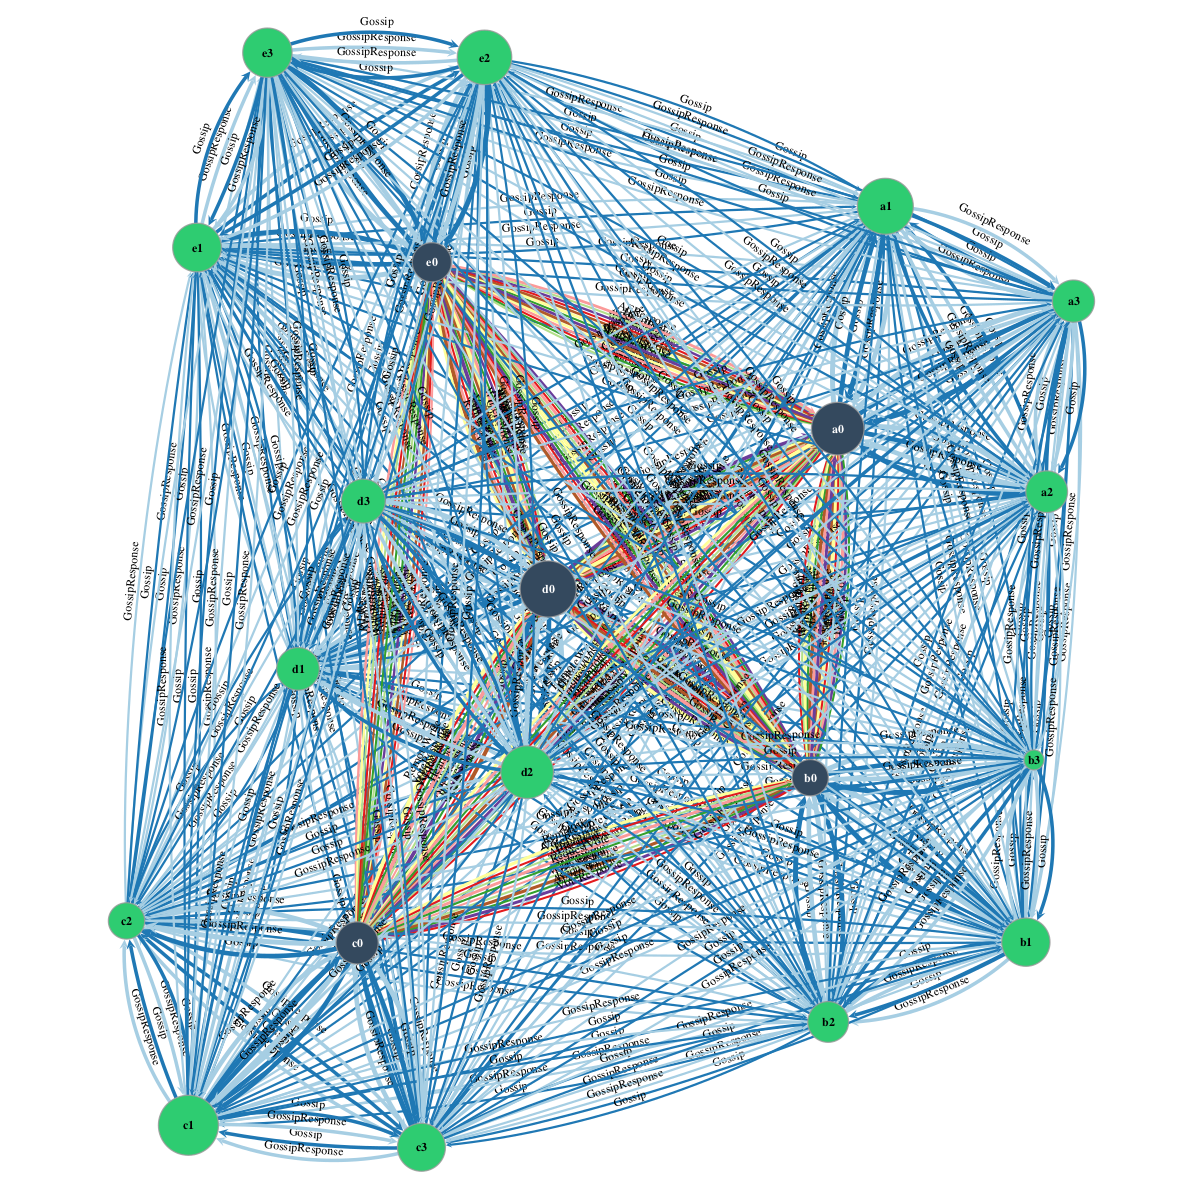

<PropertyMap object with key type 'Vertex' and value type 'vector<double>', for Graph 0x1214eca50, at 0x12434db90>

In [26]:
def find_results(etype='federated', Po=None):
    for result in get_results_data():
        if result.settings['type'] == etype: 
            if (Po and str(Po) == result.settings['outage_prob']) or Po is None:
                name = "{}-Po{}.pdf".format(etype, Po)
                return result, name    
    return None, None 


# Find the desired results 
result, name = find_results('federated', 0.55)
if result is None: raise ValueError("Could not find results!")

# Extract the Graph Tool graph     
G = extract_graph(result, by_message_type=True)

# Draw the graph 
vlabel  = G.vp['id']
vsize   = G.vp['writes']
vsize   = gt.prop_to_size(vsize, ma=60, mi=20)

# Set the vertex color 
vcolor  = G.new_vertex_property('string') 
vcmap   = ColorMap('flatui', shuffle=False)
for vertex in G.vertices():
    vcolor[vertex] = vcmap(G.vp['consistency'][vertex])

# Set the edge color 
ecolor  = G.new_edge_property('string')
ecmap   = ColorMap('paired', shuffle=False)
for edge in G.edges():
    ecolor[edge] = ecmap(G.ep['label'][edge])

elabel  = G.ep['label']
esize   = G.ep['norm']
esize   = gt.prop_to_size(esize, mi=2, ma=5)

# Create the layout with the edge weights. 
# pos = gt.arf_layout(G, weight=G.ep['weight'])
pos = gt.sfdp_layout(G, eweight=G.ep['weight'], vweight=vsize)
# pos = gt.fruchterman_reingold_layout(G, weight=G.ep['weight'])

gt.graph_draw(
    G, pos=pos, output_size=(1200,1200), output=os.path.join(FIGURES, name),
    vertex_text=vlabel, vertex_size=vsize, vertex_font_weight=1, 
    vertex_pen_width=1.3, vertex_fill_color=vcolor,
    edge_pen_width=esize, edge_color=ecolor, edge_text=elabel
)

In [27]:
# Open the README and print the description 
with open(os.path.join("..", "fixtures", "experiments", "federated", "outages", "README.md")) as f:
    print(f.read())

traced 28,792 accesses on 20 devices over 4,320,034 timesteps (1 hour 12 minutes 0 second)
object space contains 28 object names:
  10 average objects per device | 7 average devices per object
  1,439 average accesses per device | 143 average accesses per object
wrote the trace file to /Users/benjamin/Repos/umd/cloudscope/fixtures/experiments/federated/outages/access.tsv

outages-01.tsv: 0 offline events 

outages-02.tsv: 2 offline events averaging 2 minutes 40 seconds
outages-02.tsv: 2 online events averaging 17 minutes 59 seconds

outages-03.tsv: 3 offline events averaging 2 minutes 13 seconds
outages-03.tsv: 3 online events averaging 15 minutes 19 seconds

outages-04.tsv: 5 offline events averaging 2 minutes 40 seconds
outages-04.tsv: 6 online events averaging 10 minutes 0 second

outages-05.tsv: 8 offline events averaging 2 minutes 19 seconds
outages-05.tsv: 8 online events averaging 6 minutes 45 seconds

outages-06.tsv: 7 offline events averaging 2 minutes 51 seconds
outages-06.ts